<div class="alert alert-block alert-info"><h1>交互式可视化-疫情分布图</h1></div>


## 一. 期望效果

绘制省份和各省份下辖市的疫情分布图，达到点击省份方块出现下辖市疫情分布图，再次点击返回省份疫情分布图，点击时间轴切换日期，点击播放按钮自动播放省份数据变化或城市数据变化的效果。

## 二. 注意事项

* 本案例基于Jupyter Notebook，不支持Pycharm等其它IDE。
* 本案例所涉及的所有文件的编码格式均为UTF-8。
* 除常用的库之外，还需安装 ipywidgets：`!pip install ipywidgets`

## 三. 代码实现

### 1. 加载库

In [1]:
%matplotlib notebook
# %matplotlib notebook 将会把交互式的绘图嵌入到notebook中
import re,copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display,HTML

### 2. 数据处理

#### 2.1 数据来源:[github](https://github.com/BlankerL/DXY-COVID-19-Data)
>github上文件的编码格式为UTF-8-BOM，可用[Notepad++](https://notepad-plus-plus.org/downloads/v7.8.1/)转换格式。

#### 2.2 代码目的：

原始数据储存了1月24日-3月6日的疫情数据。每天中有多次数据更新，造成重复。偶尔会有几天缺少个别省份的数据。画图需要有序的数据，原始数据不能保证绝对有序。

将原始数据去重，即每天取一条数据。如果某天某省数据缺失，则用上一次的数据代替。最终将数据按日期为首要关键字，省份名称为次要关键字，城市名称为再次要关键字排序，其中时间升序，后两者任意，保证时间从早到晚，省份、城市位置相对固定以便于观察动态变化。

#### 2.3 代码实现：

In [2]:
def data_process():
    raw_data=pd.read_csv('test_data/DXYArea.csv',encoding='utf-8') #读取原始数据
    raw_data['updateTime']=raw_data['updateTime'].map(lambda x: re.sub(' \d{2}:\d{2}:\d{2}.\d{3}','',x))
    '''
    原始数据的时间格式为：2020-03-06 16:02:02.123，为了去重的方便，
    利用正则表达式将空格及之后的时分秒删去，仅保留日期
    '''
    drop_duplicated_data = raw_data.drop_duplicates(subset=['updateTime','cityName'], keep='first')
    #去重，如果有多条数据日期相同且城市名称相同，则保留第一条，即最新一条。如此得到每天一条数据。
    
    '''
    以下循环的目的是如果某天缺少某省的数据，则用上一次数据代替。基本思路为：
    从第二天开始遍历，取出前一天的数据，将日期改为当前日期，将此数据添加进之前处理好的数据即 
    drop_duplicated_data,再次去重，且去重时取首条即最新数据，如此，若可补充出现在前一天而未出现在当前日期的数据。
    以此类推，则可将某天未出现的省份数据用上一次数据补齐。
    '''
    dates=pd.date_range(start='20200124',end='20200306') #日期列表
    for i in range(1,len(dates)):
        current_date=str(dates[i])[:10] #当前日期
        last_date=str(dates[i-1])[:10] #上一天日期
        add_df =copy.deepcopy(drop_duplicated_data.loc[drop_duplicated_data['updateTime']==last_date])
        #取出上一天的日期的数据
        
        add_df['updateTime']=add_df['updateTime'].map(lambda x: re.sub(last_date,current_date,x))
        #修改为当前日期

        drop_duplicated_data=pd.concat([drop_duplicated_data,add_df],axis=0,ignore_index=True)
        #两个dataframe拼接
        
        drop_duplicated_data=drop_duplicated_data.drop_duplicates(subset=['updateTime','cityName'], keep='first')
        #去重，取重复数据的第一条即最新数据
        
    sorted_data=drop_duplicated_data.sort_values(by=['updateTime','provinceEnglishName','cityEnglishName'],
                                           ascending=[True]*3)
    #处理完成后排序，by的参数为排序的依据关键字，ascecding=True为升序。
    return sorted_data

### 3. 画图

#### 3.1 方法简介：

在`interact_map`类中封装有如下方法:<br>
* `__init__()` 初始化，作用为数据准备及画第一幅图
* `time_axis()` 画时间轴，在画省份或城市时两个方法调用
* `draw_provinces()` 画省份
* `draw_cities()` 画城市
* `route()` 根据传入的不同参数信息决定下一步的动作

#### 3.2 大致思路：

1. 成员变量记录当前数据信息，随日期改变、分布图切换等动作而相应改变。
2. 所有画图操作都要经过`route()`方法，由其根据传入的参数或其他信息决定下一步的动作。
3. 初始化时`__init__()`加载数据，调用`route()`，`route()`根据相关信息调用`draw_provinces()`画第一幅图(默认为1月24日)
4. 当点击某省份方块时，点击事件触发`route()`并传入相应参数，`route()`调用`draw_cities()`画该省份下辖市的疫情分布图。
5. 当点击城市方块时，点击事件触发`route()`并传入相应参数，`route()`调用`draw_provinces()`画省份的分布图，如此达到点击城市图返回省份图的效果。
6. 当点击时间轴切换时间时，点击事件触发`route()`并传入相应参数，`route()`根据相应的参数选择对应日期的数据，并根据当前图像调用`draw_provinces()`或`draw_cities()`画图。(若当前为省份界面，则切换日期后应画另一个日期的省份图；若当前为某省的城市图，则切换日期后为另一个日期该省的城市图。)
7. 播放功能通过播放控件对`route()`的多次调用进而多次画图来完成。根据数据信息，可播放省份数据的动态变化，也可播放某省份城市的数据变化。

#### 3.3 代码实现：

interact_map类中封装了与画图直接相关的方法和用到的一些变量:

In [3]:
class interact_map(object):
    __cmap = plt.cm.YlOrRd #调色板，根据数据大小返回深浅不一的颜色，这里为红色和黄色的搭配色
    __positions=[0.275*i for i in range(-3,40)] #生成日期在时间轴上的位置
    __dates=[str(date)[5:10] for date in pd.date_range(start='20200124',end='20200306')] #生成日期列表
    __date_positions=dict(zip(__dates,__positions)) 
    #将日期和位置合并为字典,键为日期，值为该日期在时间轴上的位置参数，用于画时间轴。

    #初始化
    def __init__(self,data):
        self.__current_date=None #当前日期
        self.__current_info=None #当前日期的所有信息，类型为dataframe
        self.__current_provinces_info=None #当前省份信息，即当前日期下每个省份取一条数据组成dataframe，用于画省份图
        self.__current_cities_info=None #当前日期当前省份下的城市信息，类型为dataframe
        self.__current_maxv=None #当前日期下，省份确诊人数的最大值
        self.__current_event=None #储存当前点击事件的对象，为的是获取点击方块的信息以确定点击的是哪个方块。
        self.__cid=None #储存点击事件绑定后返回的对象，用于解除绑定
        self.__total_data=data #读入数据，总数据，即之前数据处理步骤返回的所有数据
        
        self.route(None,0) #画第一幅图，参数信息见下方route()方法
        
    def draw_provinces(self):
        self.__current_event=None#每次切换省份，点击事件对象清空，同时表示当前在省份界面而不是城市界面
        fig.canvas.mpl_disconnect(self.__cid)
        #每次画图需断开之前的事件绑定，以免出现一次点击事件产生多此响应

        plt.xticks([])#隐藏x，y轴刻度
        plt.yticks([])
        self.time_axis()# 画时间轴

        #以下分别取出各省份名称、确诊、治愈、死亡人数，类型为列表
        names = self.__current_provinces_info['provinceName'].values
        confirmed = self.__current_provinces_info['province_confirmedCount'].values
        cured = self.__current_provinces_info['province_curedCount'].values
        dead = self.__current_provinces_info['province_deadCount'].values
        sumv = confirmed+cured+dead #求和，用于绘图
        self.__current_maxv=max(confirmed) #当前日期各省份中确诊人数的最大值
        i = 0
        #绘制6*6的方格状散点图，保证绘图顺序为从上到下，从左到右
        for y in range(5,-1,-1):
            for x in range(6):
                if i < len(names): #此时为非空白区
                    '''
                    picker属性表名该图形可被选取，不设置picker属性则不能被选取，此与鼠标点击时间密切相关，
                    s为大小，c为颜色，marker为形状
                    绘制底色，颜色深浅按照确诊人数决定。标签为省名称，可通过电视时间获取该标签，作为下一
                    步画那个省下辖市的依据
                    '''
                    plt.scatter(2*x,2*y,marker='s',s=4600,picker=True,
                                c=[self.__cmap(np.sqrt(np.sqrt(confirmed[i]/self.__current_maxv)))],
                                label=names[i])
                    
                    #以确诊、治愈、死亡人数对总人数的百分比确定绿色和黑色方格的大小，注意考虑覆盖部分
                    #绘制治愈人数方块，颜色为绿色，大小由人数确定
                    plt.scatter(2*x,2*y,marker='s',s=((cured[i]+dead[i])/sumv[i])*4600,c='#20bf55')

                    #绘制死亡人数方块，解释同上
                    plt.scatter(2*x,2*y,marker='s',s=(dead[i]/sumv[i])*4600,c='black')

                    '''
                    以下为文字和数据的标注，分别为省名、确诊人数、治愈人数、死亡人数
                    除黑龙江和内蒙古，其余省份简称均为全称的前两个字，再次进行相关调整。
                    '''
                    plt.text(2*x-0.9,2*y-0.7,
                            names[i][:2] if names[i]!='黑龙江省'and names[i]!='内蒙古自治区' else names[i][:3],
                            color='#757575',fontsize=14)
                    plt.text(2*x+0.9,2*y+0.5,str(confirmed[i]),horizontalalignment='right',color='red',
                             fontsize=11)
                    plt.text(2*x+0.9,2*y+0.1,str(cured[i]),horizontalalignment='right',color='#128847',
                             fontsize=11)
                    plt.text(2*x+0.9,2*y-0.3,str(dead[i]),horizontalalignment='right',color='black',fontsize=11)
                else:#此时为空白区域，填充灰色
                    plt.scatter(2*x,2*y,marker='s',s=4600,c='#f2f2f3')
                i+=1

        #绑定鼠标点击事件
        self.__cid=fig.canvas.mpl_connect('pick_event',lambda event: self.route(event,'from_draw_provinces'))
        #重新绘图
        fig.canvas.draw()
    
    #draw_cities()与draw_provinces()重复的部分不再赘述
    def draw_cities(self):
        fig.canvas.mpl_disconnect(self.__cid)

        plt.xticks([])
        plt.yticks([])
        self.time_axis()

        #如果列表为空，即无当前信息，即当前省份在当前日期下无患者，此时画空白方格
        if len(self.__current_cities_info)==0:
            for y in range(5,-1,-1):
                for x in range(6):
                    plt.scatter(2*x,2*y,marker='s',s=4600,c='#dddde1',picker=True)
        else:
            #取出储存的城市名称、城市确诊、治愈、死亡人数，以下类似于draw_province的某些部分
            names=self.__current_cities_info['cityName'].values
            confirmed = self.__current_cities_info['city_confirmedCount'].values
            cured = self.__current_cities_info['city_curedCount'].values
            dead = self.__current_cities_info['city_deadCount'].values
            sumv = confirmed+cured+dead
            i = 0
            for y in range(5,-1,-1):
                for x in range(6):
                    if i < len(names):#数据共有len(names)条
                        if confirmed[i]!=0:#确诊人数不为零
                            plt.scatter(2*x,2*y,marker='s',s=4600,picker=True,
                                    c=[self.__cmap(np.sqrt(np.sqrt(confirmed[i]/self.__current_maxv)))])
                            plt.scatter(2*x,2*y,marker='s',s=((cured[i]+dead[i])/sumv[i])*4600,c='#20bf55')
                            plt.scatter(2*x,2*y,marker='s',s=(dead[i]/sumv[i])*4600,c='black')
                        else:#如果确诊人数为零
                            plt.scatter(2*x,2*y,marker='s',s=4600,c='#dddde1',picker=True)
                        if len(names[i])>4:
                            #这里，部分城市名称较长，当名称超过4个字时，我们调小字体并另起一行
                            name=names[i][:4]+'\n'+names[i][4:]
                            size=12
                        else:
                            name=names[i]
                            size=14
                        plt.text(2*x-0.9,2*y-0.7,name,color='#757575',fontsize=size)
                        plt.text(2*x+0.9,2*y+0.5,str(confirmed[i]),horizontalalignment='right',color='red',
                                 fontsize=11)
                        plt.text(2*x+0.9,2*y+0.1,str(cured[i]),horizontalalignment='right',color='#128847',
                                 fontsize=11)
                        plt.text(2*x+0.9,2*y-0.3,str(dead[i]),horizontalalignment='right',color='black',
                                 fontsize=11)
                    else:#空白区域
                        plt.scatter(2*x,2*y,marker='s',s=4600,picker=True,c='#f2f2f3')
                    i+=1

        self.__cid=fig.canvas.mpl_connect('pick_event',lambda event: self.route(event,'from_draw_draw_cities'))

        fig.canvas.draw()

    
    def time_axis(self):
        ax.axis([-3, 11, -1, 11])#x,y轴刻度的起止位置
        for date in self.__dates:#变量日期列表
            if date==self.__current_date:#画当前所处日期时，圆圈填充红色，边缘为黑色、文本颜色为黑色
                plt.scatter(-1.5,self.__date_positions[date],marker='o',c='r',s=50,edgecolors='k',picker=True,
                            label=date)
                plt.text(-2.4,self.__date_positions[date],date,c='k',fontsize=8,
                         horizontalalignment='center',verticalalignment='center')
            else:#非当前日期的圆圈及文本，圆圈空心，边缘即文本为灰色
                plt.scatter(-1.5,self.__date_positions[date],marker='o',c='',edgecolors='darkgray',
                                                                    s=50,picker=True,label=date)
                plt.text(-2.4,self.__date_positions[date],date,c='gray', fontsize=8,
                         horizontalalignment='center',verticalalignment='center')
    
    '''
    `route()`根据传入的不同参数决定下一步的动作，在这里"event"为点击事件返回的对象，"come_from"表明触发route()
    的函数是哪一个。有关"come_from"的判断有下列几种可能:
    1. 首先判断是否为数字，若为数字，则为初始化或播放控件传入参数，下一步应该切换时间并画图(该数字为日期在列表中
        的的索引，通过该数字获得日期)
    2.对于点击时间轴切换日期，由于时间轴在`draw_provinces`，`draw_cities`中绘制，"come_from"的值为"from_draw_
        provinces"或"from_draw_cities",并不能区分是点击方块还是点击时间轴圆圈，所以我们用获取标签即
        `event.artist.get_label()`来区别。如果标签内容以数字开头，即内容为一个日期，则由点击时间轴触发，下一步切
        换日期画图。
    3. 若标签内容不以数字开头即不是日期且"come_from"为"from_draw_provinces":表明由点击`draw_provinces`的方块触
        发，下一步则应画城市。
    4. 若标签内容不以数字开头即不是日期且"come_from"为"from_draw_cities":表明由点击`draw_cities`的方块触发，下
        一步则应画省份。
    '''
    def route(self,event,come_from):
        #以下两行保证中文、负号的正常显示
        plt.rcParams['font.sans-serif'] = ['SimHei']
        plt.rcParams['axes.unicode_minus'] = False
        ax.axis([-3, 11, -1, 11])#坐标轴刻度的起止位置
        plt.axis('scaled')#固定长宽比
        plt.cla() #由于每次画图都要经过route，在这里删除之前画的图
        
    #如果comefrom是数字(播放控件传参)，或者标签以数字开头(为日期，表示点击时间轴触发)则下一步应该切换日期并画图
        if str(come_from).isdigit() or event.artist.get_label()[0].isdigit():
            if str(come_from).isdigit():#如果为播放控件传参
                self.__current_date=self.__dates[come_from] #更新当前日期
            else:#如果为点击时间轴触发
                self.__current_date=event.artist.get_label() #更新当前日期
            
            #更新新的日期下的数据信息
            self.__current_info=(self.__total_data.loc[self.__total_data['updateTime'] ==
                                                   '2020-'+self.__current_date])
            
            if self.__current_event==None:#如果当前点击事件为空，即未点击省份方块，即当前界面为省份
                #更新省份信息，即在当前日期下，每个省份选一条数据组成dataframe
                self.__current_provinces_info=(self.__current_info.drop_duplicates(subset=['provinceName'],
                                                                                   keep='first'))
                self.draw_provinces()#画省份，实现省份疫情信息的播放
            else:#若当前点击事件不为空，即已点击省份方块，即当前界面为城市
                #更新城市信息，即在当前日期下，选择指定省份的城市信息组成dataframe
                self.__current_cities_info=(self.__current_info.loc[(self.__current_info['provinceName']==
                                                                     self.__current_event.artist.get_label())])
                self.draw_cities()#画城市，实现当前省份城市疫情的播放
        else:#此时为点击省份或城市方块
            if come_from=='from_draw_provinces':#由点击省份触发
                self.__current_event=event #更新点击事件
                #更新城市信息
                self.__current_cities_info=(self.__current_info.loc[(self.__current_info['provinceName']==
                                                                self.__current_event.artist.get_label())])
                self.draw_cities() #画城市
            else: #由点击城市触发
                self.draw_provinces() #画省份

以上为interact_map类的全部内容，包含了直接画图的所有变量和函数。下面是通过播放控件实现自动播放功能，PyCharm等其他IDE并不支持此控件。

In [4]:
def play_box():
    #进度条，value为初始值，min,max,step为最大最小值和步长，readout为是否显示当前值
    slider = widgets.IntSlider(value=0,min=0,max=42,step=1,bar_style='success',orientation='horizontal',
                               readout=False)
    #播放按钮，interval为间隔时间，单位为毫秒，这里设置为600毫秒
    play = widgets.Play(interval=600,value=0,min=0,max=42,step=1,description="Press play",disabled=False)
    widgets.jslink((play, 'value'), (slider,'value'))
    #将播放按钮和进度条以其各自的value为纽带连接起来，达到两个数值同步的效果
    return widgets.HBox([play,slider]),slider #两个对象合并为一个组件，并返回

def play_fun(date_index):#进度条数值的变化会多次调用此函数，从而多次自动调用route而多次画图实现动态播放功能
    draw_map.route(None,date_index)


运行代码

<IPython.core.display.Javascript object>


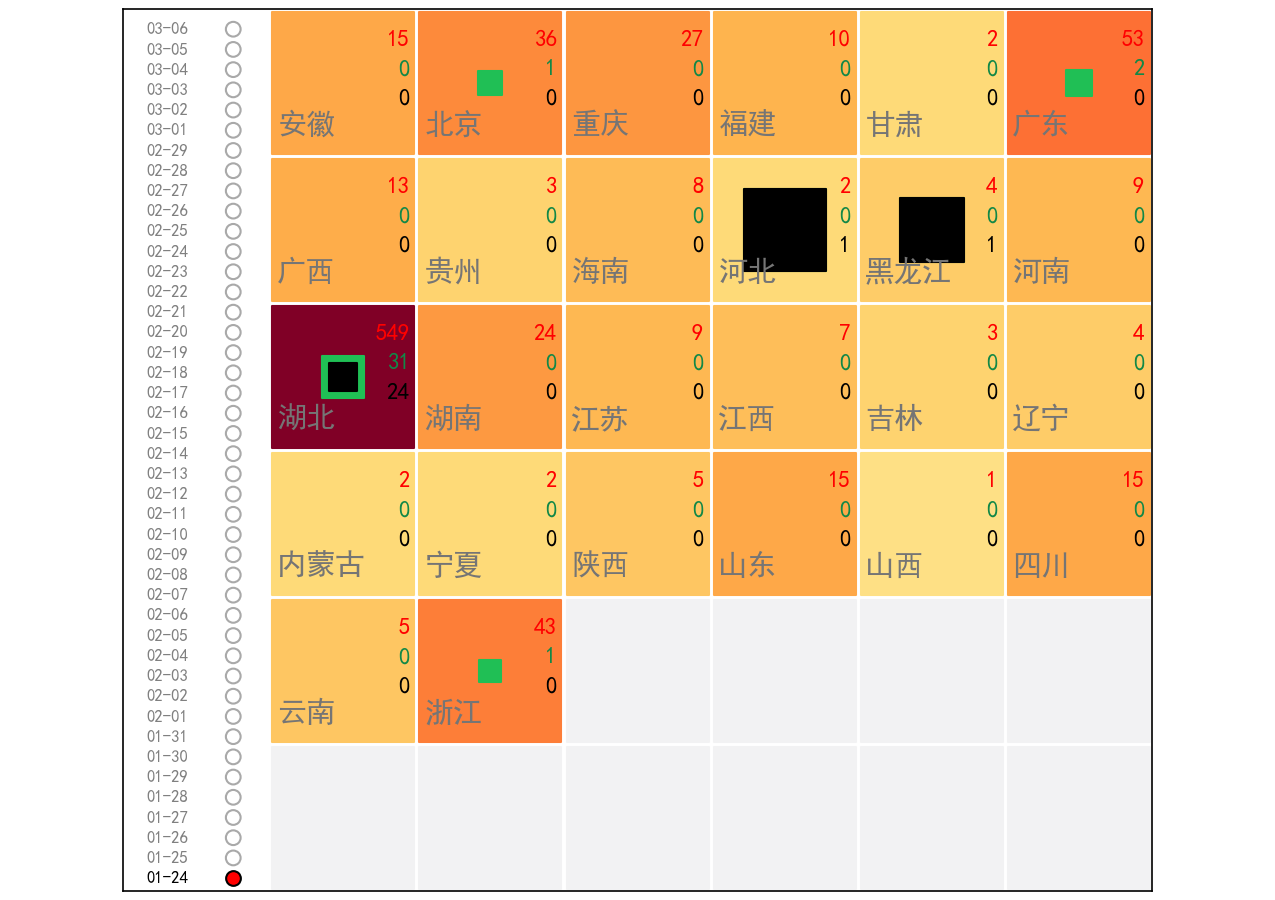

Output()

In [5]:
fig= plt.figure(figsize=(8.5,6))
ax=plt.axes([0.01,0.01,0.98,0.98])#左下宽高,为对figure大小的百分比

draw_map=interact_map(data_process())#初始化，同时执行data_process()，传入处理后的数据

box,slider=play_box() #获取组合控件对象和进度条
out = widgets.interactive_output(play_fun, {'date_index': slider})#进度条与play_fun关联。进度条会调用该函数

display(box,out) 
#展示组合控件，这里播放按钮控件与进度条关联，进度条值与play_fun关联，进度条的值多次传入play_fun
                                                                #由此实现多次调用route()画图的效果
plt.show()